# Error Analysis Dataset Generation

- Stage 0: basic prompt
- Stage 1: selecting reference objects
- Stage 2: pointing out the objects movements/objects viewpoints changes
- Stage 3: given reasoning chain, use greedy strategy

The conetents of this notebook:

0. Useful text pre-define
> *answer candidates options*
1. C1 generation
> *iterate the image in side each dof, record dof, direction(+/-), label, (prompt0, label_idx0), ..., (prompt3, label_idx3)*
2. C2 generation

In [1]:
from pathlib import Path

dataset_dir = Path("/home/u5u/kdeng.u5u/spatial-reasoning-of-LMs/demo")

In [2]:
c1_dir = dataset_dir / "single-dof-camera-motion-demo"
c2_dir = dataset_dir / "obj-centered-view-shift-demo"

In [3]:
import glob

def _read_c1_path_list(c1_dir: Path):
    c1_path_list = []
    for dof_dir in c1_dir.iterdir():
        if dof_dir.is_dir():
            for scene_dir in dof_dir.iterdir():
                if scene_dir.is_dir():
                    for seq_dir in scene_dir.iterdir():
                        if seq_dir.is_dir():
                            for pair_dir in seq_dir.iterdir():
                                if pair_dir.is_dir():
                                    src_dir = pair_dir / "source"
                                    tgt_dir = pair_dir / "target"

                                    src_img = glob.glob(str(src_dir / "*.color.png"))
                                    tgt_img = glob.glob(str(tgt_dir / "*.color.png"))

                                    c1_path_list.append((src_img[0], tgt_img[0]))
                            
    return c1_path_list


def _read_c2_path_list(c2_dir: Path):
    c2_path_list = []
    for tau_dir in c2_dir.iterdir():
        if tau_dir.is_dir():
            for scene_dir in tau_dir.iterdir():
                if scene_dir.is_dir():
                    for pair_dir in scene_dir.iterdir():
                        if pair_dir.is_dir():
                            src_dir = pair_dir / "source"
                            tgt_dir = pair_dir / "target"

                            src_img = glob.glob(str(src_dir / "*.jpg"))
                            tgt_img = glob.glob(str(tgt_dir / "*.jpg"))

                            c2_path_list.append((src_img[0], tgt_img[0]))
    
    return c2_path_list

In [4]:
c1_path_list = _read_c1_path_list(c1_dir)
c2_path_list = _read_c2_path_list(c2_dir)

In [5]:
new_dataset_file = Path("/home/u5u/kdeng.u5u/spatial-reasoning-of-LMs/demo/error-analysis.jsonl")
c2_error_analysis_file = Path("/home/u5u/kdeng.u5u/spatial-reasoning-of-LMs/demo/error-analysis-c2.jsonl")

## Useful Pre-define

In [6]:
label_map = {
    "theta": {
        "+": "upward_rotation",
        "-": "downward_rotation",
    },
    "phi": {
        "+": "rightward_rotation",
        "-": "leftward_rotation",
    },
    "psi": {
        "+": "clockwise_rotation",
        "-": "counterclockwise_rotation",
    },
    "tx": {
        "+": "rightward_translation",
        "-": "leftward_translation",
    },
    "ty": {
        "+": "downward_translation",
        "-": "upward_translation",
    },
    "tz": {
        "+": "forward_translation",
        "-": "backward_translation",
    },
}

ans_cand_map = {
    "theta": {
        "+": "Upward Rotation - The camera rotates upward from source viewpoint to target viewpoint.",
        "-": "Downward Rotation - The camera rotates downward from source viewpoint to target viewpoint.",
    },
    "phi": {
        "+": "Rightward Rotation - The camera rotates rightward from source viewpoint to target viewpoint.",
        "-": "Leftward Rotation - The camera rotates leftward from source viewpoint to target viewpoint.",
    },
    "psi": {
        "+": "Clockwise Rotation - The camera rotates clockwise from source viewpoint to target viewpoint.",
        "-": "Counterclockwise Rotation - The camera rotates counterclockwise from source viewpoint to target viewpoint.",
    },
    "tx": {
        "+": "Rightward Translation - The camera translates rightward from source viewpoint to target viewpoint.",
        "-": "Leftward Translation - The camera translates leftward from source viewpoint to target viewpoint.",
    },
    "ty": {
        "+": "Downward Translation - The camera translates downward from source viewpoint to target viewpoint.",
        "-": "Upward Translation - The camera translates upward from source viewpoint to target viewpoint.",
    },
    "tz": {
        "+": "Forward Translation - The camera translates forward from source viewpoint to target viewpoint.",
        "-": "Backward Translation - The camera translates backward from source viewpoint to target viewpoint.",
    },
}

obj_move_template = {
    "left": "The {obj} looks to move leftward from the source viewpoint to the target viewpoint.",
    "right": "The {obj} looks to move rightward from the source viewpoint to the target viewpoint.",
    "up": "The {obj} looks to move upward from the source viewpoint to the target viewpoint.",
    "down": "The {obj} looks to move downward from the source viewpoint to the target viewpoint.",
    "closer": "The {obj} looks to move closer from the source viewpoint to the target viewpoint.",
    "farther": "The {obj} looks to move farther from the source viewpoint to the target viewpoint.",
    "clockwise": "The {obj} looks to rotate clockwise from the source viewpoint to the target viewpoint.",
    "counterclockwise": "The {obj} looks to rotate counterclockwise from the source viewpoint to the target viewpoint.",

    "view_change": "The {obj} is in a {src_view} in the source viewpoint and a {tgt_view} in the target viewpoint.",
}

inverse_map = {
    "left": "right",
    "right": "left",
    "leftward": "right",
    "rightward": "left",
    "up": "down",
    "down": "up",
    "upward": "down",
    "downward": "up",
    "forward": "closer",
    "backward": "farther",
    "clockwise": "counterclockwise",
    "counterclockwise": "clockwise",
}

In [7]:
prompt_template = """<input>
You are given two images. The first image is the source viewpoint, and the second image is the target viewpoint.
</input>

<task>
Your task is to infer the camera motion from the source viewpoint to the target viewpoint. You are given some answer candidates, and you need to select the most appropriate one.
</task>

{hint}

<answer-candidates>
{answer_candidates}
</answer-candidates>

<output-format>
Please output your reasoning in <rsn></rsn> XML tags first, and then output the index of the answer-candidate you choose in <ans></ans> XML tags. Do not output any other text.
</output-format>"""


In [ ]:
# def _generate_prompt(ans_cands: list, **kwargs) -> str:
#     answer_candidates = "\n".join(f"{idx}. {ans}" for idx, ans in enumerate(ans_cands))
#     hint = kwargs.get("hint", "")
#     thinking = kwargs.get("thinking", "")
    
#     return prompt_template.format(
#         hint=hint,
#         thinking=thinking,
#         answer_candidates=answer_candidates
#     )

# import re

In [9]:
# hint part
def _generate_hint_part_by_mode(mode: int, objs_prompt, objs_move_prompt, thinking_prompt) -> str:
    if mode == 0:
        return ""
    elif mode == 1:
        return objs_prompt
    elif mode == 2:
        return objs_prompt + "\n\n" + objs_move_prompt
    elif mode == 3:
        return objs_prompt + "\n\n" + objs_move_prompt + "\n\n" + thinking_prompt

## C1 Generation

Contents in this sec:
1. iterate each image pair
2. show the image pair
3. curate hint and thinking part in text
4. find correct index

In [26]:
from matplotlib import pyplot as plt
from PIL import Image
import json

def _show_images(image_paths: tuple):
    src_img, tgt_img = image_paths

    src_img = Image.open(src_img)
    tgt_img = Image.open(tgt_img)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(src_img)
    ax[0].set_title("Source Viewpoint")
    ax[0].axis("off")

    ax[1].imshow(tgt_img)
    ax[1].set_title("Target Viewpoint")
    ax[1].axis("off")

    plt.show()


i = 0
def _next(image_list: list):
    global i
    image_paths = next(image_list)
    i += 1
    _show_images(image_paths)
    print(f"Processing image pair {i}, remaining {len(c1_path_list) - i} pairs.")

    metadata_path = Path(image_paths[0]).parent.parent / "metadata.json"
    with open(metadata_path) as f:
        metadata = json.load(f)
    return image_paths, metadata


In [ ]:
c1_iter = iter(c1_path_list)

: 

: 

: 

: 

Manually create the dataset, the output is different types of prompt and the correct index of the answer

In [11]:
# # Iterate images
# image_paths, metadata = _next(c1_iter)
# dof = metadata["significance"]
# sign = "+" if metadata[dof] > 0 else "-"
# print(f"Degree of Freedom: {dof}\nSign: {sign}")

# # 1. Collecting objects from user input
# objs = []
# while True:
#     obj = input("Enter your object (or 'done' to stop): ")
#     if obj.lower() == 'done':
#         break
#     objs.append(obj)
# print(f"Collected objects: {objs}")

# objs_prompt = """<objects>
# Please compare the position of following objects in the source viewpoint and target viewpoint. They can be the reference objects to help you understand the camera motion.
# {objs}
# </objects>"""
# objs_prompt = objs_prompt.format(objs="\n".join(f"{idx+1}: {obj}" for idx, obj in enumerate(objs)))

# # 2. Generate the objects movements
# # while True:
# #     obj_move_input = input("Enter the object movement description (e.g., 'left', 'right', 'up', 'down', 'closer', 'farther', 'clockwise', 'counterclockwise'): ")
# #     if obj_move_input not in ["left", "right", "up", "down", "closer", "farther", "clockwise", "counterclockwise"]:
# #         print("Invalid input. Please try again.")
# #         continue
# #     break
# obj_move_input = inverse_map[metadata["significance_text"]]
# obj_move_temp = obj_move_template[obj_move_input]

# objs_move_prompt = """<hint>
# {objs_move}
# </hint>"""
# objs_move_prompt = objs_move_prompt.format(objs_move="\n".join(f"{idx+1}: {obj_move_temp.format(obj=obj)}" for idx, obj in enumerate(objs)))

# # 3. Generate the camera movements thinking
# thinking_prompt = """<thinking>
# The camera-perspective and object-perspective are inverse, causing the camera movement to appear reversed relative to the object's movement.
# </thinking>"""

# # 4. Generate answer candidates part
# answer_candidates = [ans for ans in ans_cand_map[dof].values()]
# import random
# random.shuffle(answer_candidates)
# cor_idx = answer_candidates.index(ans_cand_map[dof][sign])
# ans_cand_prompt = "\n".join(f"{idx}. {ans}" for idx, ans in enumerate(answer_candidates))

# # 5. Generate final prompt with 4 modes.
# prompt_list = []
# for mode in [0, 1, 2, 3]:
#     hint_part_prompt = _generate_hint_part_by_mode(
#         mode,
#         objs_prompt,
#         objs_move_prompt,
#         thinking_prompt,
#     )
#     prompt = prompt_template.format(
#         hint=hint_part_prompt,
#         answer_candidates=ans_cand_prompt,
#     )
#     prompt_list.append(prompt)

# # 6. Print to check
# # for prompt in prompt_list:
# #     print(f"The label here is {label_map[dof][sign]}")
# #     print(f"The correct index is {cor_idx}")
# #     print(prompt)

# # 7. Generate row
# row = {
#     "src_img_path": image_paths[0],
#     "tgt_img_path": image_paths[1],
#     "dof": dof,
#     "sign": sign,
#     "label": label_map[dof][sign],
#     "prompt0": prompt_list[0],
#     "prompt1": prompt_list[1],
#     "prompt2": prompt_list[2],
#     "prompt3": prompt_list[3],
#     "cor_idx": cor_idx,
# }

# import jsonlines
# with jsonlines.open(new_dataset_file, mode='a') as writer:
#     writer.write(row)
# print(f"Written to {new_dataset_file} successfully.")

In [12]:
# # Check the row with jsonlines
# with jsonlines.open(new_dataset_file, 'r') as f:
#     for line in f:
#         print(line["label"])
#         print(line["cor_idx"])
#         print(line["prompt0"])
#         print(line["prompt1"])
#         print(line["prompt2"])
#         print(line["prompt3"])

## C2 Generation

In this section, we follow the `func` in C1 generation: `show_image` and `_next`. Unlike pointing out objects movements, we provide the view change of objects (also because *C2 dataset* has larger viewpoint change than *C1 dataset*), e.g., the object is in {{front-view}} in source viewpoint and in {{left-view}} in the target view.

In [13]:
prompt_template = """<input>
You are given two images. The first image is the source viewpoint, and the second image is the target viewpoint. From source viewpoint to target viewpoint, the camera is moving around, i.e., with translation and rotation.
</input>

<task>
Your task is to infer the camera motion from the source viewpoint to the target viewpoint. You are given some answer candidates, and you need to select the most appropriate one in describing the camera motion in translation or rotation.
</task>

{hint}

<answer-candidates>
{answer_candidates}
</answer-candidates>

<output-format>
Please output your reasoning in <rsn></rsn> XML tags first, and then output the index of the answer-candidate you choose in <ans></ans> XML tags. Do not output any other text.
</output-format>"""

In [27]:
c2_iter = iter(c2_path_list)

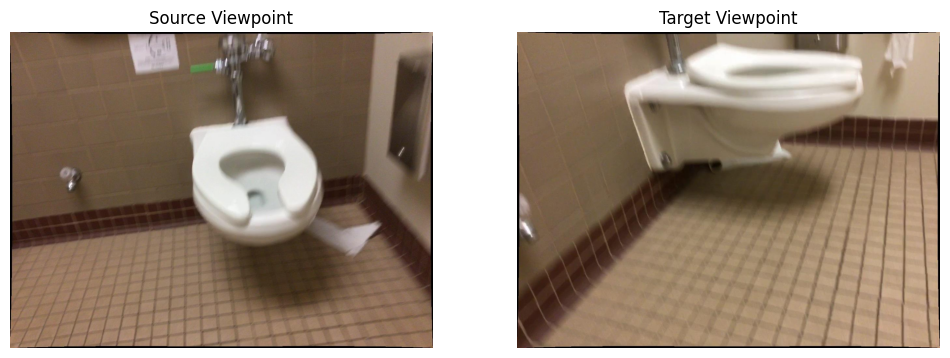

Processing image pair 3, remaining 26 pairs.


In [30]:
# image_paths, metadata = _next(c2_iter)

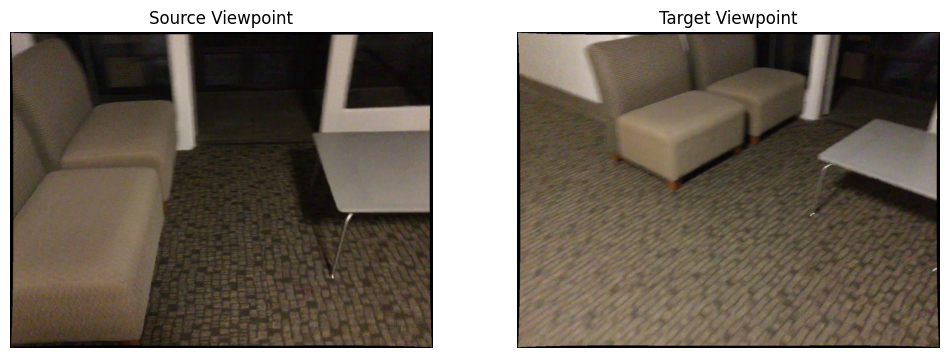

Processing image pair 29, remaining 0 pairs.
The angle between images: 27.170022
Phi Degree of Freedom: leftward
Phi Sign: -
Tx Degree of Freedom: right
Tx Sign: +
Collected objects: ['White Coffee Table']
Object Source View: front-view
Object Target View: right-view
Written to /home/u5u/kdeng.u5u/spatial-reasoning-of-LMs/demo/error-analysis-c2.jsonl successfully.
Written to /home/u5u/kdeng.u5u/spatial-reasoning-of-LMs/demo/error-analysis-c2.jsonl successfully.


In [56]:
# Iterate images
image_paths, metadata = _next(c2_iter)
phi_label = metadata["phi_text"]
phi_sign = "+" if metadata["phi"] > 0 else "-"
tx_label = metadata["tx_text"]
tx_sign = "+" if metadata["tx"] > 0 else "-"
print(f"The angle between images: {metadata['angle']}")
print(f"Phi Degree of Freedom: {phi_label}\nPhi Sign: {phi_sign}")
print(f"Tx Degree of Freedom: {tx_label}\nTx Sign: {tx_sign}")

# 1. Collecting objects from user input
objs = []
while True:
    obj = input("Enter your OBJECT (or ⚠️⚠️⚠️ 'done' to STOP!!!!): ")
    if obj.lower() == 'done':
        break
    objs.append(obj)
print(f"Collected objects: {objs}")

objs_prompt = """<objects>
Please compare the position of following objects in the source viewpoint and target viewpoint. They can be the reference objects to help you understand the camera motion.
{objs}
</objects>"""
objs_prompt = objs_prompt.format(objs="\n".join(f"{idx+1}: {obj}" for idx, obj in enumerate(objs)))

# 2. Generate the objects movements
while True:
    obj_src_view = input("Enter the viewpoint of the object in the SOURCE viewpoint: ")
    if not obj_src_view.endswith("-view"):
        print("Invalid input. Please try again.")
        continue
    obj_tgt_view = input("Enter the viewpoint of the object in the TARGET viewpoint: ")
    if not obj_tgt_view.endswith("-view"):
        print("Invalid input. Please try again.")
        continue
    break
print(f"Object Source View: {obj_src_view}\nObject Target View: {obj_tgt_view}")
obj_view_change = obj_move_template["view_change"]

objs_move_prompt = """<hint>
{objs_move}
</hint>""".format(objs_move="\n".join(f"{idx+1}: {obj_view_change.format(obj=obj, src_view=obj_src_view, tgt_view=obj_tgt_view)}" for idx, obj in enumerate(objs)))

# 3. Generate the camera movements thinking
thinking_prompt = """<thinking>
The camera-perspective and object-perspective are inverse, causing the camera movement to appear reversed relative to the object's movement.
</thinking>"""

# 4. Generate answer candidates part for phi and tx
for dof in ["phi", "tx"]:
    sign = phi_sign if dof == "phi" else tx_sign
    answer_candidates = [ans for ans in ans_cand_map[dof].values()]
    import random
    random.shuffle(answer_candidates)
    cor_idx = answer_candidates.index(ans_cand_map[dof][sign])
    ans_cand_prompt = "\n".join(f"{idx}. {ans}" for idx, ans in enumerate(answer_candidates))

    # 5. Generate final prompt with 4 modes.
    prompt_list = []
    for mode in [0, 1, 2, 3]:
        hint_part_prompt = _generate_hint_part_by_mode(
            mode,
            objs_prompt,
            objs_move_prompt,
            thinking_prompt,
        )
        prompt = prompt_template.format(
            hint=hint_part_prompt,
            answer_candidates=ans_cand_prompt,
        )
        prompt_list.append(prompt)

    # 6. Print to check
    # for prompt in prompt_list:
    #     print(prompt)

    # 7. Generate row
    row = {
        "src_img_path": image_paths[0],
        "tgt_img_path": image_paths[1],
        "dof": dof,
        "sign": sign,
        "angle": metadata["angle"],
        "label": label_map[dof][sign],
        "prompt0": prompt_list[0],
        "prompt1": prompt_list[1],
        "prompt2": prompt_list[2],
        "prompt3": prompt_list[3],
        "cor_idx": cor_idx,
    }

    import jsonlines
    with jsonlines.open(c2_error_analysis_file, mode='a') as writer:
        writer.write(row)
    print(f"Written to {c2_error_analysis_file} successfully.")